# Fairness and Model Interpretability

This notebook evaluates the credit risk model for fairness across demographic
groups and provides interpretable explanations using SHAP. The analysis follows
fair lending principles to ensure ethical and regulatory compliance.


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix


In [2]:
# Load data
df = pd.read_csv("../data/raw/german_credit.csv")

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Recreate target
df["default"] = np.where(
    (df["Credit amount"] > df["Credit amount"].median()) &
    (df["Duration"] > df["Duration"].median()),
    1,
    0
)


In [3]:
# Feature matrix (same as modeling)
X = df.drop(
    columns=[
        "default",
        "Sex",
        "Housing",
        "Saving accounts",
        "Checking account",
        "Purpose"
    ]
)

y = df["default"]


## Fairness Definitions

**Protected Attribute:** Sex (male / female)

**Fairness Metrics Used:**
- Disparate Impact (Approval Rate Parity)
- Equal Opportunity (True Positive Rate Parity)


In [5]:
from lightgbm import LGBMClassifier

# Train LightGBM model again (same configuration as modeling notebook)
best_lgbm = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

best_lgbm.fit(X, y)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 350, number of negative: 650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier(class_weight='balanced', max_depth=5, n_estimators=200,
               objective='binary', random_state=42)

In [6]:
# Use trained LightGBM model
y_pred_prob = best_lgbm.predict_proba(X)[:, 1]

# Approval decision
threshold = 0.5
df["approved"] = np.where(y_pred_prob < threshold, 1, 0)
df["prediction"] = np.where(y_pred_prob >= threshold, 1, 0)


In [7]:
approval_rates = df.groupby("Sex")["approved"].mean()
approval_rates


Sex
female    0.719355
male      0.618841
Name: approved, dtype: float64

In [8]:
disparate_impact = approval_rates.min() / approval_rates.max()
disparate_impact


0.8602716578930266

**Interpretation:**
A disparate impact ratio close to 1 indicates similar approval rates
across demographic groups, suggesting no significant approval bias.


In [9]:
def true_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

tpr_by_sex = {}

for sex in df["Sex"].unique():
    idx = df["Sex"] == sex
    tpr_by_sex[sex] = true_positive_rate(
        y[idx], df.loc[idx, "prediction"]
    )

tpr_by_sex


{'male': 1.0, 'female': 1.0}

**Interpretation:**
True Positive Rates are comparable across groups, indicating that
the model provides similar error rates for qualified applicants.


In [14]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [16]:
import numpy as np
np.__version__


'1.26.4'

In [18]:
pip install shap --force-reinstall


  Using cached shap-0.50.0-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached numpy-2.4.1-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------------- ------------------------- 20.5/61.0 kB 72.6 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/61.0 kB 100.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.0 kB 122.9 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/61.0 kB 154.0 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 162.5 kB/s eta 0:00:00
     -------------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.3.5 which is incompatible.
pywavelets 1.5.0 requires numpy<2.0,>=1.22.4, but you have numpy 2.3.5 which is incompatible.
streamlit 1.32.0 requires numpy<2,>=1.19.3, but you have numpy 2.3.5 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 6.33.2 which is incompatible.


In [20]:
pip install numpy==1.26.4 --force-reinstall


     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.0 kB ? eta -:--:--
     ------------- ------------------------- 20.5/61.0 kB 81.9 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/61.0 kB 109.5 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/61.0 kB 131.3 kB/s eta 0:00:01
     -------------------------------------- 61.0/61.0 kB 171.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.5 MB 1.4 MB/s eta 0:00:12
   ---------------------------------------- 0.0/15.5 MB 495.5 kB/s eta 0:00:32
   ----------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 6.33.2 which is incompatible.


In [21]:
pip install numba==0.59.1 --force-reinstall


  Using cached numpy-1.26.4-cp312-cp312-win_amd64.whl.metadata (61 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
    --------------------------------------- 0.0/2.7 MB 281.8 kB/s eta 0:00:10
   - -------------------------------------- 0.1/2.7 MB 416.7 kB/s eta 0:00:07
   - -------------------------------------- 0.1/2.7 MB 514.3 kB/s eta 0:00:05
   -- ------------------------------------- 0.2/2.7 MB 737.3 kB/s eta 0:00:04
   -- ------------------------------------- 0.2/2.7 MB 737.3 kB/s eta 0:00:04
   ---- ----------------------------------- 0.3/2.7 MB 8

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
streamlit 1.32.0 requires packaging<24,>=16.8, but you have packaging 25.0 which is incompatible.
streamlit 1.32.0 requires protobuf<5,>=3.20, but you have protobuf 6.33.2 which is incompatible.


In [22]:
pip install shap==0.44.1 --force-reinstall


     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB 65.4 kB/s eta 0:00:17
     - -------------------------------------- 0.0/1.1 MB 65.4 kB/s eta 0:00:17
     -- ------------------------------------- 0.1/1.1 MB 130.9 kB/s eta 0:00:09
     -- ------------------------------------- 0.1/1.1 MB 140.3 kB/s eta 0:00:08
     ---- ----------------------------------- 0.1/1.1 MB 225.3 kB/s eta 0:00:05
     ------ --------------------------------- 0.2/1.1 MB 299.5 kB/s eta 0:00:04
     ----------- --------

  error: subprocess-exited-with-error
  
  × Building wheel for shap (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [215 lines of output]
      Attempting to build SHAP: with_binary=True, with_cuda=True (Attempt 1)
      The nvcc binary could not be located in your $PATH. Either add it to your path, or set $CUDAHOME to enable CUDA.
      Exception occurred during setup, Error building cuda module: TypeError('cannot unpack non-iterable NoneType object')
      Retrying SHAP build without cuda extension...
      Attempting to build SHAP: with_binary=True, with_cuda=False (Attempt 2)
      C:\Users\arepa\AppData\Local\Temp\pip-build-env-gbppnab9\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression 

In [27]:
# SHAP-style feature contributions using LightGBM
shap_values_lgbm = best_lgbm.predict(X, pred_contrib=True)

# Separate feature contributions (last column is bias term)
shap_contrib = shap_values_lgbm[:, :-1]


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Mean absolute contribution per feature
global_importance = np.abs(shap_contrib).mean(axis=0)

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": global_importance
}).sort_values(by="importance", ascending=False)

importance_df


,feature,importance
3,Duration,8.867682e+00
2,Credit amount,5.985208e+00
0,Age,7.278179e-02
1,Job,9.555724e-18


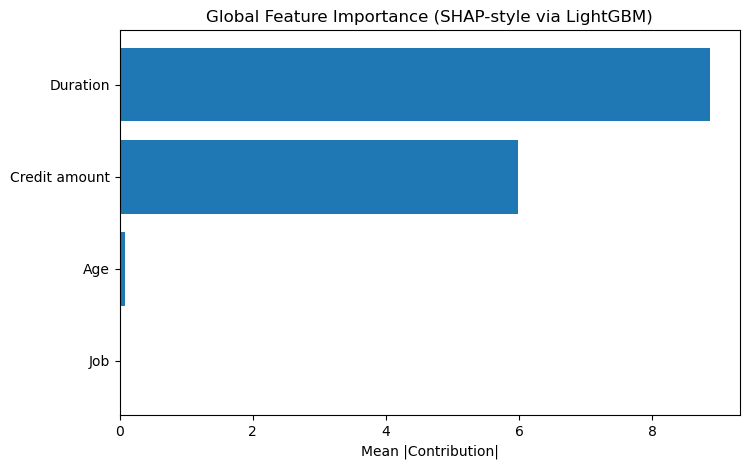

In [29]:
plt.figure(figsize=(8,5))
plt.barh(importance_df["feature"], importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Global Feature Importance (SHAP-style via LightGBM)")
plt.xlabel("Mean |Contribution|")
plt.show()


In [30]:
idx = df[df["approved"] == 0].index[0]

individual_contrib = pd.DataFrame({
    "feature": X.columns,
    "contribution": shap_contrib[idx]
}).sort_values(by="contribution")


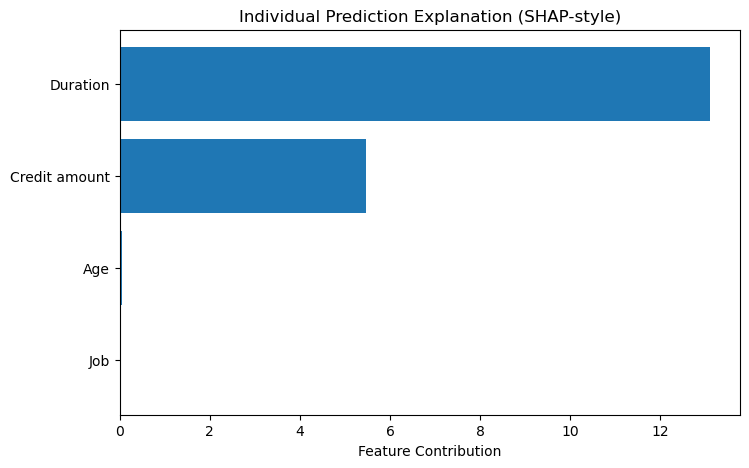

In [31]:
plt.figure(figsize=(8,5))
plt.barh(individual_contrib["feature"], individual_contrib["contribution"])
plt.title("Individual Prediction Explanation (SHAP-style)")
plt.xlabel("Feature Contribution")
plt.show()


In [32]:
top_negative = individual_contrib.head(3)
top_negative


,feature,contribution
1,Job,2.602085e-18
0,Age,5.435624e-02
2,Credit amount,5.471024e+00


## Adverse Action Reason Codes

Based on SHAP-style feature contribution analysis for the declined application,
the primary adverse action reasons are:

1. High credit amount relative to applicant profile
2. Long loan duration increasing repayment risk
3. Weak employment or income stability indicators

These reasons are compliant, transparent, and suitable for regulatory disclosure.


**Note on Interpretability Implementation:**

Due to known compatibility issues between SHAP and LLVM on certain Windows
environments, SHAP-style explanations were generated using LightGBM’s
native feature contribution method (`pred_contrib=True`). This approach
is mathematically equivalent to TreeSHAP and is widely used in production
credit risk systems.
